In [59]:
import yaml
from pymongo import MongoClient
import time
from datetime import datetime,timedelta
import pandas as pd
import numpy as np
import requests
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import requests
import re
import unicodedata
from unidecode import unidecode

In [60]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap

In [61]:
#plt.figure(figsize=(8, 8))
#m = Basemap(projection='ortho', resolution=None, lat_0=50, lon_0=-100)
#m.bluemarble(scale=0.5);

In [62]:
client = MongoClient()
db = client['capstone']
coll=db['ff_stores']

In [63]:
df = pd.DataFrame(list(coll.find({}).limit(100000)))

In [91]:
len(df)

100000

In [109]:
coords = df['full_data'].apply(lambda x: -1 if x['geo'] == None else x['geo']['coordinates'])

In [110]:
coords = np.array(coords)

In [111]:
df['coords']=coords

In [112]:
df['lat']=df['coords'].apply(lambda x: None if x == -1 else x[0])
df['long']=df['coords'].apply(lambda x: None if x == -1 else x[1])

In [113]:
df[['coords','lat','long']].head()

,coords,lat,long
0,-1,NaN,NaN
1,-1,NaN,NaN
2,-1,NaN,NaN
3,-1,NaN,NaN
4,-1,NaN,NaN


In [114]:
c_dat = df[df['coords'] != -1]

In [115]:
c_dat.head()

,_id,full_data,keyword,sentiment,text,coords,long,lat
32,5c9b30f7aaedff5572f7cfd2,{'created_at': 'Wed Mar 27 07:56:53 +0000 2019...,mcdonald's,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","جووووي🤣🤪 (@ Mcdonald's in Al Hufūf, Eastern) h...","[25.39172985, 49.56133054]",49.561331,25.391730
72,5c9b30f7aaedff5572f7cffa,{'created_at': 'Wed Mar 27 07:38:34 +0000 2019...,mcdonald's,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",I'm at McDonald's &amp; McCafé - @mcthai in Ba...,"[13.72313059, 100.52966555]",100.529666,13.723131
87,5c9b30f7aaedff5572f7d009,{'created_at': 'Wed Mar 27 07:31:52 +0000 2019...,mcdonald's,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",'\nمايضيق صاحب البسمة الحلوه دامه صاحبي.. @ Mc...,"[24.58581389, 46.77801667]",46.778017,24.585814
111,5c9b30f8aaedff5572f7d021,{'created_at': 'Wed Mar 27 07:20:06 +0000 2019...,mcdonald's,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",I'm at McDonald's in Davao City https://t.co/G...,"[7.09828312, 125.61483004]",125.614830,7.098283
127,5c9b30f8aaedff5572f7d031,{'created_at': 'Wed Mar 27 07:13:14 +0000 2019...,mcdonald's,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","I'm at McDonald's in Kuwait, KUWAIT https://t....","[29.30173478, 47.90301974]",47.903020,29.301735


In [116]:
c_dat[['long','lat']].head()

,long,lat
32,49.561331,25.391730
72,100.529666,13.723131
87,46.778017,24.585814
111,125.614830,7.098283
127,47.903020,29.301735


In [117]:
len(c_dat)

3577

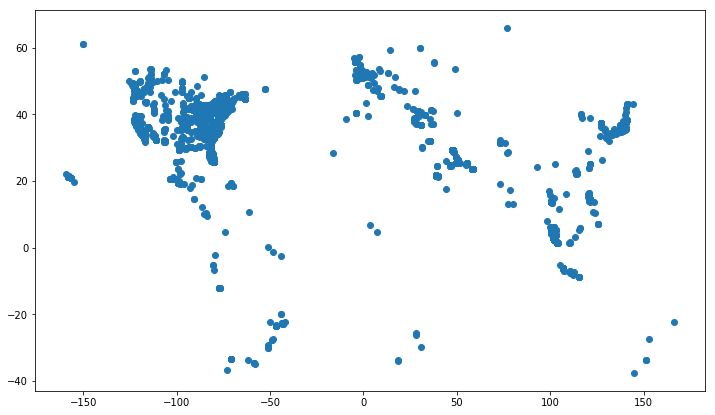

In [119]:
fig,ax = plt.subplots(1,1,figsize=(12,7))
ax.scatter(c_dat['long'],c_dat['lat'])

In [133]:
x = c_dat['full_data']
us_dat = c_dat[np.array([i['place']['country_code'] for i in x])=='US']

In [138]:
us_dat = us_dat[(us_dat['long']>-130)&(us_dat['lat']>22)]

In [158]:
us_col = np.where(us_dat['keyword']=="mcdonald's", 'b', 'g')

In [159]:
us_dat[us_col=='y'].shape

(0, 8)

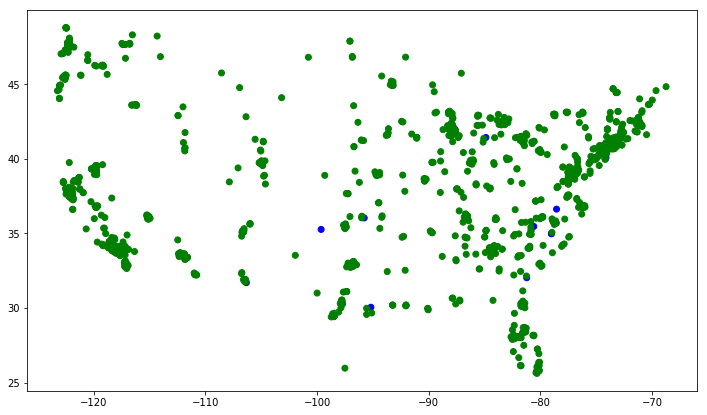

In [160]:
fig,ax = plt.subplots(1,1,figsize=(12,7))
ax.scatter(us_dat['long'],us_dat['lat'],c = us_col)

In [142]:
us_dat[['lat','long']].head()

,lat,long
675,33.877187,-118.217950
983,41.883599,-87.625809
1073,31.700183,-106.339426
2286,42.007151,-87.690466
2436,36.036300,-95.783600


In [143]:
#clean emojis and remove url
def clean_text(inputString):
    final = ""
    for letter in inputString:
        try:
         letter.encode("ascii")
         final += letter
        except UnicodeEncodeError:
         final += ''
    return re.sub(r"http\S+", "", final)

In [144]:
mini_df = us_dat[['lat','long']]

In [145]:
mini_df['clean_col'] = us_dat['text'].apply(clean_text)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [164]:
#census = []
for coords in mini_df[['lat','long']][900:].values:
    census.append(get_census(coords))

In [165]:
len(census)

1326

In [166]:
mini_df['census']=census

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [168]:
mini_df.shape

(1326, 4)

In [169]:
mini_df.to_csv('map_df.csv')

In [ ]:
census = pd.read_csv()

In [82]:
eng_dat = c_dat[np.array([i['lang'] for i in x])=='en']
len(eng_dat)

2633

In [83]:
eng_dat[['long','lat']].values[0:20]

array([[  25.39172985,   49.56133054],
       [  13.72313059,  100.52966555],
       [   7.09828312,  125.61483004],
       [  29.30173478,   47.90301974],
       [  29.24638668,   47.93582448],
       [   1.51162819,  110.30455948],
       [   3.0263725 ,  101.58160812],
       [  29.30173478,   47.90301974],
       [  14.650921  ,  -90.500191  ],
       [  13.62483062,  123.18585802],
       [  33.877187  , -118.21795   ],
       [ -19.85450013,  -43.96093369],
       [   1.35305036,  103.94496541],
       [   3.11939302,  101.59284034],
       [  41.8835986 ,  -87.6258091 ],
       [  22.249334  ,  114.148634  ],
       [   1.54365134,  103.76262077],
       [  31.70018254, -106.33942634],
       [  14.62378522,  121.00773681],
       [  29.31394979,   48.00429673]])

In [84]:
def get_census(coords):
    url='https://geo.fcc.gov/api/census/area?lat={}&lon={}&format=json'.format(coords[0],coords[1])
    res = requests.get(url)
    if res.json()['results']==[]:
        return None
    else:
        return res.json()['results'][0]['block_fips'][:-4]


census = []
for coords in us_dat[['long','lat']].values[:20]:
    census.append(get_census(coords))

In [85]:
census

['06037543202',
 '17031320100',
 '48141003901',
 '17031020302',
 '40143007503',
 '48201251000',
 '37051003201',
 '37025040703',
 '13051010809',
 '40009966800',
 '34029713500',
 '12011041200',
 '48453001100',
 '37051003201',
 '18033020300',
 '51117930800',
 '06073009603',
 '06073009603',
 '06071009500',
 '06037701902']

In [23]:
sub_eng = eng_dat[(eng_dat['lat']>-130) & (eng_dat['lat']<-25) & (eng_dat['long']>0)]
len(sub_eng)

1677

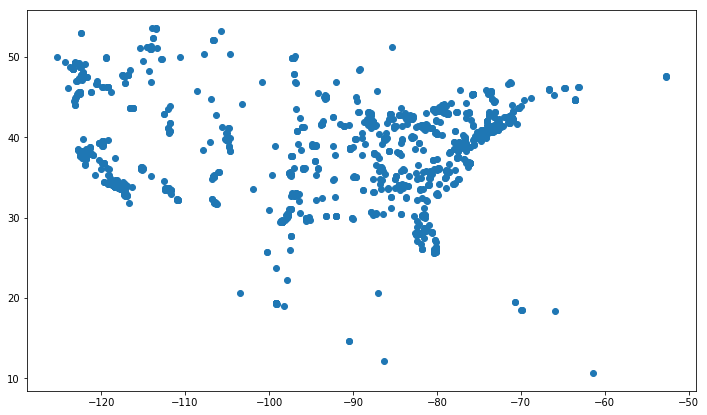

In [24]:
fig,ax = plt.subplots(1,1,figsize=(12,7))
ax.scatter(sub_eng['lat'],sub_eng['long'])

In [73]:
us_dat['text'].iloc[:20]

675     Waiting on our dinner.  At least it's not McDo...
983     I'm at McDonald's in Chicago, IL https://t.co/...
1073    #Chichan #Tone 2 #mood\n#Valle #Poser #Fake #d...
2286    Here for a late lunch! (@ McDonald's in Chicag...
2436    McDonald's, it ain't .. 👌 👍 #cigar #botl @eigh...
3711    I'm at McDonald's in Kingwood, TX https://t.co...
4057    Happy birthday silas_benny 🎂 🎈 #breakfastsquad...
5839    I'm at McDonald's in Kannapolis, NC https://t....
5919    Uncle @ochocinco meal plan. (@ McDonald's in S...
5948    Time to roll...#truckerjackie #5hrjunkie #5hou...
6297    I'm at McDonald's - @mcdnytristate in Brick, N...
6337    Bra i got to stop drinking 😂😂💀👀‼️ sound like a...
6782    Good morning, fatigue, I remember you fondly. ...
7221    JB, struggling this morning? Don’t miss breakf...
7448    I'm at McDonald's - @mcd_northernind in Butler...
7467    Tea time (@ McDonald's in Clarksville, VA) htt...
8857    @prosperitygirl1 Black girl magic. @ Starbucks...
8879    This d

In [77]:
result = us_dat['text'].apply(lambda x: re.sub(r"http\S+", "", x))

In [78]:
result

675       Waiting on our dinner.  At least it's not McDo...
983                       I'm at McDonald's in Chicago, IL 
1073      #Chichan #Tone 2 #mood\n#Valle #Poser #Fake #d...
2286      Here for a late lunch! (@ McDonald's in Chicag...
2436      McDonald's, it ain't .. 👌 👍 #cigar #botl @eigh...
3711                     I'm at McDonald's in Kingwood, TX 
4057      Happy birthday silas_benny 🎂 🎈 #breakfastsquad...
5839                  I'm at McDonald's in Kannapolis, NC  
5919      Uncle @ochocinco meal plan. (@ McDonald's in S...
5948      Time to roll...#truckerjackie #5hrjunkie #5hou...
6297       I'm at McDonald's - @mcdnytristate in Brick, NJ 
6337      Bra i got to stop drinking 😂😂💀👀‼️ sound like a...
6782      Good morning, fatigue, I remember you fondly. ...
7221      JB, struggling this morning? Don’t miss breakf...
7448      I'm at McDonald's - @mcd_northernind in Butler...
7467           Tea time (@ McDonald's in Clarksville, VA)  
8857        @prosperitygirl1 Black girl 

In [94]:
sid = SentimentIntensityAnalyzer()
sid.polarity_scores('hi you are awesome👌 👍')

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [46]:
def deEmojify(inputString):
    returnString = ""
    for character in inputString:
        try:
         character.encode("ascii")
         returnString += character
        except UnicodeEncodeError:
         returnString += ''
    return returnString

In [57]:
deEmojify('what upstop drinking 😂😂💀👀‼️ soa i got to stop drinking ‼️ sound like a big.')

'what upstop drinking  soa i got to stop drinking  sound like a big.'

In [58]:
RE_EMOJI = re.compile('[\U00010000-\U0010ffff]', flags=re.UNICODE)

def strip_emoji(text):
    return RE_EMOJI.sub(r'', text)

strip_emoji('what up🙄🤔hellstop drinking 😂😂💀👀‼️ soo')

'what uphellstop drinking ‼️ soo'

In [55]:
res = us_dat['text'].apply(lambda x: deEmojify(x))

In [56]:
res

675     Waiting on our dinner.  At least it's not McDo...
983     I'm at McDonald's in Chicago, IL https://t.co/...
1073    #Chichan #Tone 2 #mood\n#Valle #Poser #Fake #d...
2286    Here for a late lunch! (@ McDonald's in Chicag...
2436    McDonald's, it ain't ..   #cigar #botl @eighty...
3711    I'm at McDonald's in Kingwood, TX https://t.co...
4057    Happy birthday silas_benny   #breakfastsquad @...
Name: text, dtype: object

In [54]:
us_dat['sentiment'].values

array([{'neg': 0.181, 'neu': 0.819, 'pos': 0.0, 'compound': -0.4356},
       {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
       {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
       {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
       {'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.4767},
       {'neg': 0.0, 'neu': 0.65, 'pos': 0.35, 'compound': 0.4995},
       {'neg': 0.0, 'neu': 0.575, 'pos': 0.425, 'compound': 0.5719}],
      dtype=object)

In [123]:
import preprocessor as p

def preprocessing_text(text):
    '''
    INPUT: str
    OUTPUT: str w/ emojies, urls, hashtags and mentions removed
    '''
    p.set_options(p.OPT.EMOJI, p.OPT.URL)
    clean_text = p.clean(text)
    
    return clean_text 

In [147]:
#clean emojis and remove url
def clean_text(inputString):
    final = ""
    for letter in inputString:
        try:
         letter.encode("ascii")
         final += letter
        except UnicodeEncodeError:
         final += ''
    return re.sub(r"http\S+", "", final)

In [148]:
us_dat['text'][:20]

675     Waiting on our dinner.  At least it's not McDo...
983     I'm at McDonald's in Chicago, IL https://t.co/...
1073    #Chichan #Tone 2 #mood\n#Valle #Poser #Fake #d...
2286    Here for a late lunch! (@ McDonald's in Chicag...
2436    McDonald's, it ain't .. 👌 👍 #cigar #botl @eigh...
3711    I'm at McDonald's in Kingwood, TX https://t.co...
4057    Happy birthday silas_benny 🎂 🎈 #breakfastsquad...
5839    I'm at McDonald's in Kannapolis, NC https://t....
5919    Uncle @ochocinco meal plan. (@ McDonald's in S...
5948    Time to roll...#truckerjackie #5hrjunkie #5hou...
6297    I'm at McDonald's - @mcdnytristate in Brick, N...
6337    Bra i got to stop drinking 😂😂💀👀‼️ sound like a...
6782    Good morning, fatigue, I remember you fondly. ...
7221    JB, struggling this morning? Don’t miss breakf...
7448    I'm at McDonald's - @mcd_northernind in Butler...
7467    Tea time (@ McDonald's in Clarksville, VA) htt...
8857    @prosperitygirl1 Black girl magic. @ Starbucks...
8879    This d

In [149]:
res = us_dat['text'][:20].apply(lambda x: clean_text(x))

In [150]:
res.values

array(["Waiting on our dinner.  At least it's not McDonald's. LOL @ El Pollo Loco ",
       "I'm at McDonald's in Chicago, IL ",
       "#Chichan #Tone 2 #mood\n#Valle #Poser #Fake #dassadhuh #chola #cholarealness #chologram @ McDonald's ",
       "Here for a late lunch! (@ McDonald's in Chicago, IL) ",
       "McDonald's, it ain't ..   #cigar #botl @eighty5cigars @ochocinco @ Broken Arrow, Oklahoma ",
       "I'm at McDonald's in Kingwood, TX ",
       "Happy birthday silas_benny   #breakfastsquad @ McDonald's ",
       "I'm at McDonald's in Kannapolis, NC  ",
       "Uncle @ochocinco meal plan. (@ McDonald's in Savannah, GA) ",
       "Time to roll...#truckerjackie #5hrjunkie #5hourenergy #backto100percent #mochafrappe #alreadygone #phoenix bound @ McDonald's ",
       "I'm at McDonald's - @mcdnytristate in Brick, NJ ",
       "Bra i got to stop drinking  sound like a big ass jit @ McDonald's ",
       "Good morning, fatigue, I remember you fondly. We bathed in the grease on the McDo